## Constant nodes

It is possible to turn stateless nodes
to constant nodes, whose body is evaluated only once before the runtime,
cached and produced, to the output on demand.

The main purpose of this is to reduce the computational load of the runtime.

There are a few conditions the node should meet in order to become a constant node:

* It should be a stateless node, i.e. created via `@DeltaBlock`.

* It should use argument `allow_const=True` to say that this node can be made constant, or alternatively use `False` to ensure the node is not constant.

* All inputs should come from constant nodes, this will lead to
precompilation of multiple constant nodes before running.

* And finally, the node cannot have optional inputs, i.e. no `DOptional`, because it can
lead to non-deterministic results.

Let's start with two types of a node, as both constant and non-constant nodes:

In [1]:
import logging
import time

import deltalanguage as dl


@dl.DeltaBlock(allow_const=False)
def foo() -> int:
    time.sleep(0.1)
    print("FOO: 42")
    return 42


@dl.DeltaBlock(allow_const=True)
def foo_const() -> int:
    time.sleep(0.1)
    print("FOO: 42")
    return 42


@dl.DeltaBlock(allow_const=False)
def bar(a: int) -> int:
    time.sleep(0.1)
    print("BAR:", a)
    return a


@dl.DeltaBlock(allow_const=True)
def bar_const(a: int) -> int:
    time.sleep(0.1)
    print("BAR:", a)
    return a


s = dl.lib.StateSaver(int, verbose=True) # helper node that saves the result

Note that we've added `sleep` statements.
This illustrates that the node can be doing a very long and hard computation with each evaluation,
even though the message sent is always the same.

### Case 1: normal to normal

In this case neither node is cached:

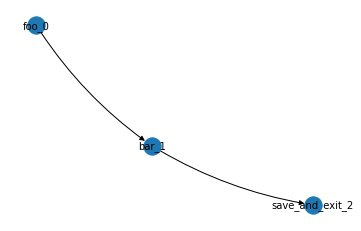

In [2]:
with dl.DeltaGraph() as graph:
    foo_out = foo()
    bar_out = bar(foo_out)
    s.save_and_exit(bar_out)

graph.draw(seed=1)

We turn both the runtime and message logging on to show the amount of messages
sent in the graph before the graph finally exits:

In [3]:
rt = dl.DeltaPySimulator(graph, lvl=logging.INFO, msg_lvl=logging.INFO)
rt.run()

# check the result
assert s.saved[-1] == 42

DeltaPySimulator [INFO]: creating queue: foo_0_________________________ to bar_1.a_______________________ DInt32______________
DeltaPySimulator [INFO]: creating queue: bar_1_________________________ to save_and_exit_2.val___________ DInt32______________
DeltaPySimulator [INFO]: Starting node foo_0
DeltaPySimulator [INFO]: Starting node bar_1
DeltaPySimulator [INFO]: Starting node save_and_exit_2
DeltaPySimulator [INFO]: Total number of threads = 4
FOO: 42
FOO: 42
BAR: 42
saving 42
MessageLog [INFO]: Sent to bar_1 port a at logical clock time 1: 42
MessageLog [INFO]: Sent to bar_1 port a at logical clock time 2: 42
MessageLog [INFO]: Sent to save_and_exit_2 port val at logical clock time 2: 42
FOO: 42
BAR: 42


This log is disproportionately long for such a simple task.
The first node in the graph continuely produces more and more
messages that triggers the following nodes to re-run again and agian.
This significantly slows down the running stage and clog
the queues exchanging data between nodes.

### Case 2: const to normal

In this case only the first node is cached:

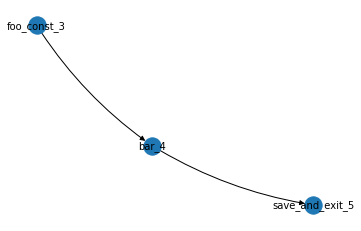

In [4]:
with dl.DeltaGraph() as graph:
    foo_out = foo_const()
    bar_out = bar(foo_out)
    s.save_and_exit(bar_out)

graph.draw(seed=1)

Note a significant reduction of messages, but still a lot of
unnecessary computations are done multiple times:

In [5]:
rt = dl.DeltaPySimulator(graph, lvl=logging.INFO, msg_lvl=logging.INFO)
rt.run()

# check the result
assert s.saved[-1] == 42

DeltaPySimulator [INFO]: creating queue: foo_const_3___________________ to bar_4.a_______________________ DInt32______________
DeltaPySimulator [INFO]: creating queue: bar_4_________________________ to save_and_exit_5.val___________ DInt32______________
DeltaPySimulator [INFO]: Starting node bar_4
DeltaPySimulator [INFO]: Starting node save_and_exit_5
DeltaPySimulator [INFO]: Total number of threads = 3
FOO: 42
BAR: 42
saving 42
MessageLog [INFO]: Sent to bar_4 port a at logical clock time 1: 42
MessageLog [INFO]: Sent to bar_4 port a at logical clock time 1: 42
MessageLog [INFO]: Sent to save_and_exit_5 port val at logical clock time 2: 42
BAR: 42


### Case 3: const to const

In this case both nodes are cached:

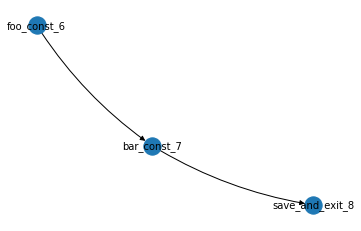

In [6]:
with dl.DeltaGraph() as graph:
    foo_out = foo_const()
    bar_out = bar_const(foo_out)
    s.save_and_exit(bar_out)

graph.draw(seed=1)

Note how faster it is now:

In [7]:
rt = dl.DeltaPySimulator(graph, lvl=logging.INFO, msg_lvl=logging.INFO)
rt.run()

# check the result
assert s.saved[-1] == 42

DeltaPySimulator [INFO]: constant queue: foo_const_6___________________ to bar_const_7.a_________________ DInt32______________ is not created
DeltaPySimulator [INFO]: creating queue: bar_const_7___________________ to save_and_exit_8.val___________ DInt32______________
DeltaPySimulator [INFO]: Starting node save_and_exit_8
DeltaPySimulator [INFO]: Total number of threads = 2
MessageLog [INFO]: Sent to save_and_exit_8 port val at logical clock time 1: 42
FOO: 42
BAR: 42
saving 42


Note that the queue between constant nodes is not even created,
it's all a part of the runtime optimisation.

### Conclusion

By using constant nodes you can reduce the computation load during
the runtime.

Only stateless nodes can be turned into constant nodes.

Last but not least the graph cannot consist of only constant nodes,
the runtime will throw an error in this case as there will be
nothing to compute.
This is done in analogy to the compilation process in C++, which
cannot consist of only preprocessing routines starting with `#`.